## COVID-19 ICU CASES AND VACCINATION IN ONTARIO, CANADA
#### Phuong Nguyen
#### Updated 09/02/2022

In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime
from scipy.stats import norm
import math
import seaborn as sns
#!pip install sidetable
import sidetable

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.linear_model import LinearRegression

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split



Ontario is the province that has the highest number of confirmed cases among Canada. As of February 1st, 2022, this province has the number of cases as one third of total cases in Canada with more than 1 million cases, followed by Quebec and Alberta. (Statista, 2022). In Spring 2021, the third wave of the pandemic peaked again in Canada and impacted the health care system through August 2021. 

The capacity of acute care as well as intensive care unit in many hospital were overwhelmed. 
The objective of this project was to determine the relationship between ICU current cases among Ontario hospitals and the number of fully vaccinated people during the third wave of COVID-19. Having a knowledge about the relationship might help with the prediction in ICU capacity in the future with the vaccination factor. 

This study will answer the following research question:

* Can a polynomial regression accurately predict the future ICU cases given the number of people got vaccinated?

### Data exploration

Let's first look at at ICU data in Ontario. It clearly shows that there are 2 peaks which were at around May 2021 and January 2022 when there was a new variant of COVID-19. The hospitalization number was the highest, followed by the current number of ICU and ICU cases who needed the ventilation. The ICU cases that were recovered was pretty stable and low during the covid meaning the number of cases outweighted the number of recovered cases. The numbers gradually declined and stabled in summer 2021. However, the number of hospitalizations were almost the same as the number of ICU cases with different conditions. This was the also period of time the province started to advance boosted shot for COVID-19 vaccination. 

In [2]:
# Read ICU cases data
data_icu = pd.read_csv("region_hospital_icu_covid_data.csv")

# Convert to datetime in date column
data_icu["date"] = pd.to_datetime(data_icu["date"])

# Get data from 02/01/2021 - 02/052022
data_icu = data_icu[data_icu["date"].isin(pd.date_range("2021-02-01", "2022-05-02"))]

# Subset 
data_icu = data_icu.groupby("date").sum().reset_index()
data_icu1 = data_icu[["date","icu_current_covid"]]

# Change format of date colum
data_icu1["date"] = pd.to_datetime(data_icu1["date"]).dt.strftime('%d-%m-%Y')

print("Type of each column:",data_icu.dtypes)
display(data_icu.head())
display(data_icu1.head())
print("Shape of data:", data_icu1.shape)



Type of each column: date                        datetime64[ns]
icu_current_covid                    int64
icu_current_covid_vented             int64
hospitalizations                     int64
icu_crci_total                       int64
icu_crci_total_vented                int64
icu_former_covid                     int64
icu_former_covid_vented              int64
dtype: object


/var/folders/mm/xkwtc93j5137rjy7r1cb3n8r0000gn/T/ipykernel_18116/1739188938.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_icu1["date"] = pd.to_datetime(data_icu1["date"]).dt.strftime('%d-%m-%Y')


,date,icu_current_covid,icu_current_covid_vented,hospitalizations,icu_crci_total,icu_crci_total_vented,icu_former_covid,icu_former_covid_vented
0,2021-02-01,354,260,1185,383,277,29,17
1,2021-02-02,341,253,1195,369,271,28,18
2,2021-02-03,336,254,1072,368,275,32,21
3,2021-02-04,323,241,1104,356,266,33,25
4,2021-02-05,325,225,1046,359,251,34,26


,date,icu_current_covid
0,01-02-2021,354
1,02-02-2021,341
2,03-02-2021,336
3,04-02-2021,323
4,05-02-2021,325


Shape of data: (370, 2)


No handles with labels found to put in legend.


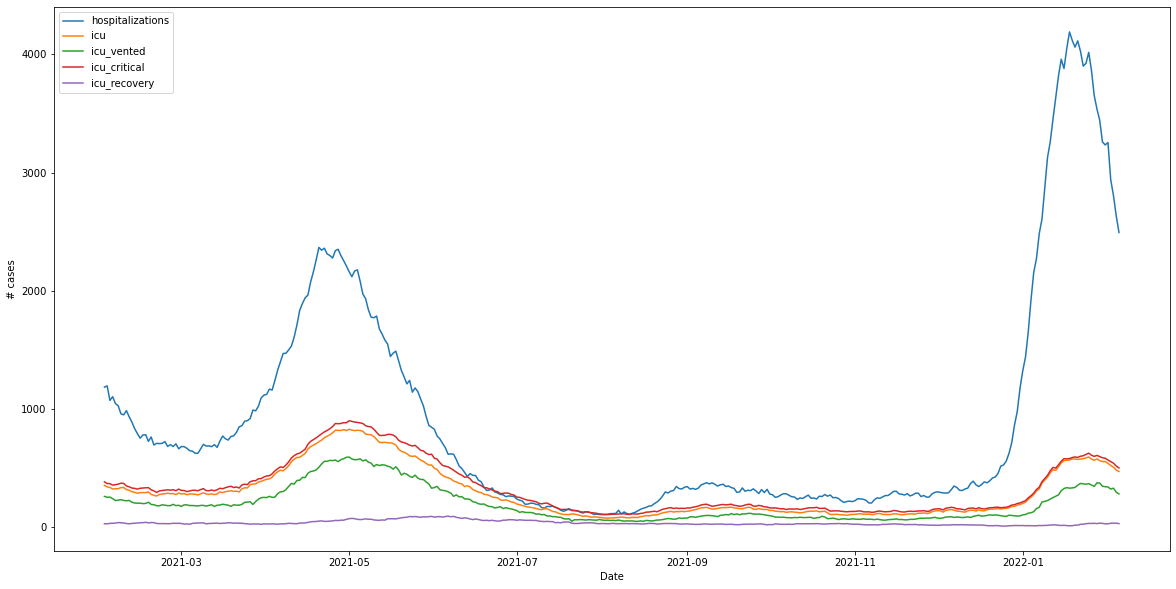

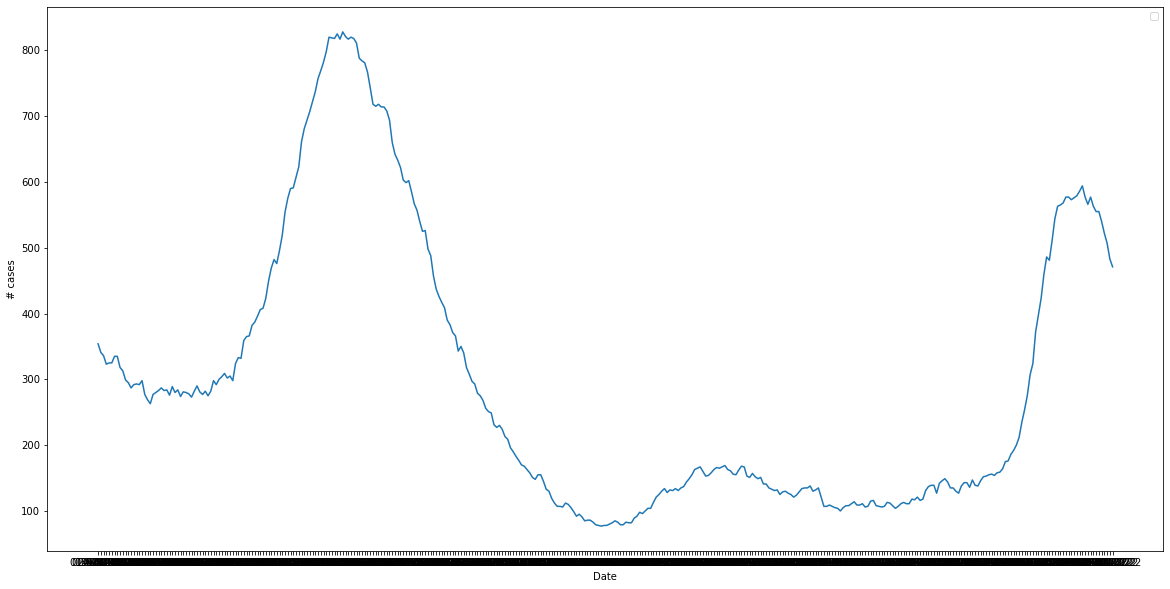

In [3]:
# Line chart of ICU cases in Ontario
plt.figure(figsize=(20,10))
plt.plot(data_icu["date"], data_icu["hospitalizations"], label="hospitalizations")
plt.plot(data_icu["date"], data_icu["icu_current_covid"], label="icu")
plt.plot(data_icu["date"], data_icu["icu_current_covid_vented"], label="icu_vented")
plt.plot(data_icu["date"], data_icu["icu_crci_total"], label="icu_critical")
plt.plot(data_icu["date"], data_icu["icu_former_covid"], label="icu_recovery")
plt.xlabel("Date")
plt.ylabel("# cases")
plt.legend()

# Line chart of current ICU cases only
plt.figure(figsize=(20,10))
plt.plot(data_icu1["date"], data_icu1["icu_current_covid"])
plt.xlabel("Date")
plt.ylabel("# cases")
plt.legend()






Now let's look at the data of vaccination in Ontario specifically. We can see that at the peak of ICU in April 2021, the number of fully vaccination was pretty low. However, from May 2021 to January 2022, ICU cases was stable as the number of vaccination with 2 shots increased significantly. 






In [50]:
# Vaccination number in Ontario
vaccines2 = pd.read_excel("vaccine_completion_timeseries_prov.xlsx")
vaccines2 = vaccines2.loc[vaccines2["province"]=="Ontario"]
vaccines2 = vaccines2[~vaccines2['date_vaccine_completed'].str.contains('-01-2021')]

print('Shape of the data:', vaccines2.shape)
display(vaccines2.head())

Shape of the data: (370, 4)


,province,date_vaccine_completed,cvaccine,cumulative_cvaccine
3140,Ontario,01-02-2021,1444.0,70293.0
3141,Ontario,02-02-2021,1764.0,72057.0
3142,Ontario,03-02-2021,2937.0,74994.0
3143,Ontario,04-02-2021,5983.0,80977.0
3144,Ontario,05-02-2021,6854.0,87831.0


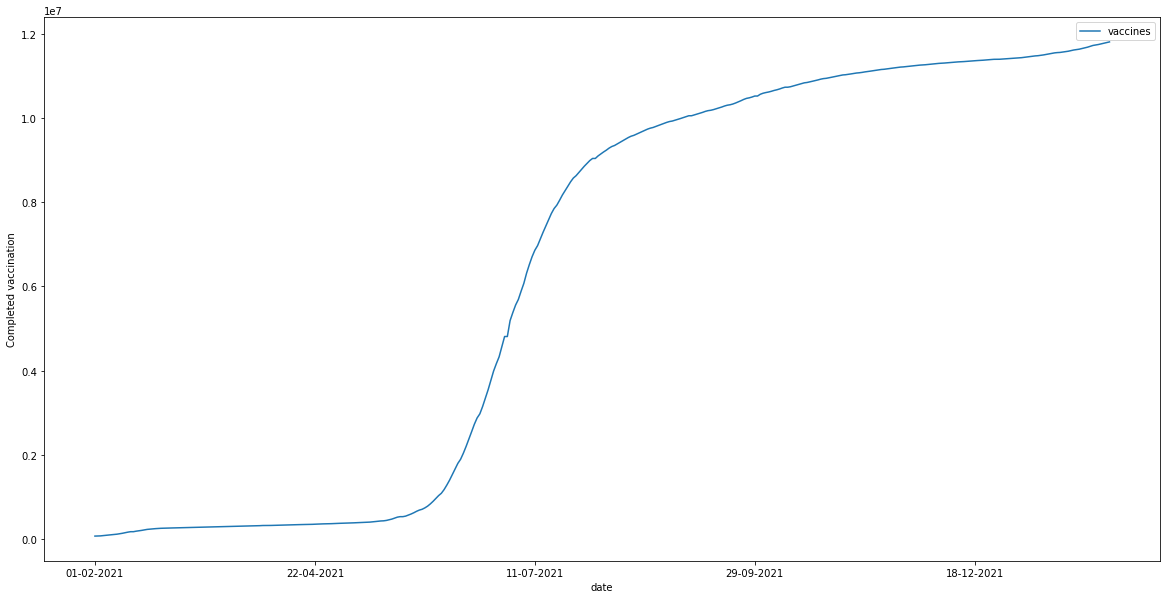

In [51]:
# Line chart of number of vaccination completed in Ontario
fig, ax = plt.subplots(1,1,figsize=(20,10))

ax.plot(vaccines2.date_vaccine_completed, vaccines2.cumulative_cvaccine, label = "vaccines")
ax.legend()
tick_spacing = 80
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
#ax.xticks(rotation=45)
ax.set_xlabel('date')
ax.set_ylabel('Completed vaccination')

plt.show()

In [171]:
# Merge data
merge_covid = pd.merge(data_icu1,vaccines2, left_on='date', right_on='date_vaccine_completed')
display(merge_covid.head())

# Subset
merge_covid = merge_covid[["date", "icu_current_covid", "cvaccine", "cumulative_cvaccine"]]

# Change datetime format
display(merge_covid.head())
print(merge_covid.dtypes)

,date,icu_current_covid,province,date_vaccine_completed,cvaccine,cumulative_cvaccine
0,01-02-2021,354,Ontario,01-02-2021,1444.0,70293.0
1,02-02-2021,341,Ontario,02-02-2021,1764.0,72057.0
2,03-02-2021,336,Ontario,03-02-2021,2937.0,74994.0
3,04-02-2021,323,Ontario,04-02-2021,5983.0,80977.0
4,05-02-2021,325,Ontario,05-02-2021,6854.0,87831.0


,date,icu_current_covid,cvaccine,cumulative_cvaccine
0,01-02-2021,354,1444.0,70293.0
1,02-02-2021,341,1764.0,72057.0
2,03-02-2021,336,2937.0,74994.0
3,04-02-2021,323,5983.0,80977.0
4,05-02-2021,325,6854.0,87831.0


date                    object
icu_current_covid        int64
cvaccine               float64
cumulative_cvaccine    float64
dtype: object


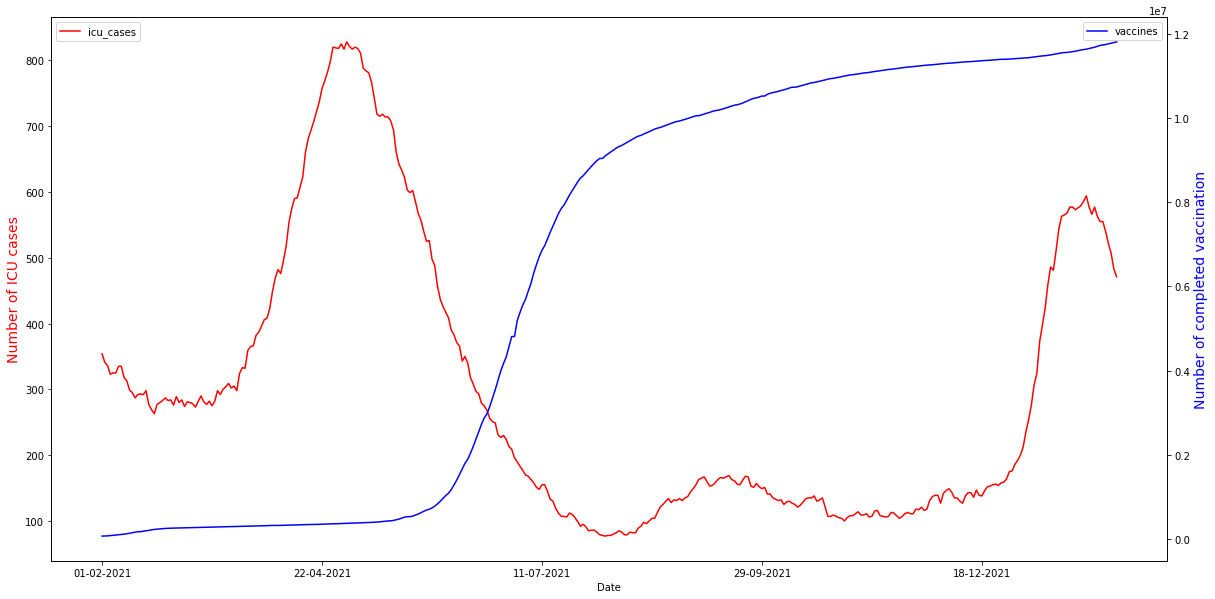

In [150]:
# Line chart of current ICU cases and number of completed vaccination
fig, ax = plt.subplots(1,1, figsize=(20,10))

ax.plot(merge_covid.date, merge_covid.icu_current_covid, label = "icu_cases",color="red")
ax.plot()
ax.legend(loc='upper left')
tick_spacing = 80
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
#ax.xticks(rotation=45)
ax.set_xlabel('Date')
ax.set_ylabel('Number of ICU cases',color="red",fontsize=14)

# twin object for two different y-axis on ßthe sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot( merge_covid.cumulative_cvaccine, label = "vaccines",color="blue")
ax2.set_ylabel("Number of completed vaccination",color="blue",fontsize=14)
ax2.legend()
plt.show()

Let's focus on the the period when vaccination number increased steadily until hitting the plateau. The time period was from Apr-22-2021 to Sep-29-2021. The relationship between ICU cases and number of fully vaccination was exmained in this period since April was peak of ICU cases when there was not much people accepted vaccination. After September 2021, there was a new variant - Omicron.

/Users/phnguyen296/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


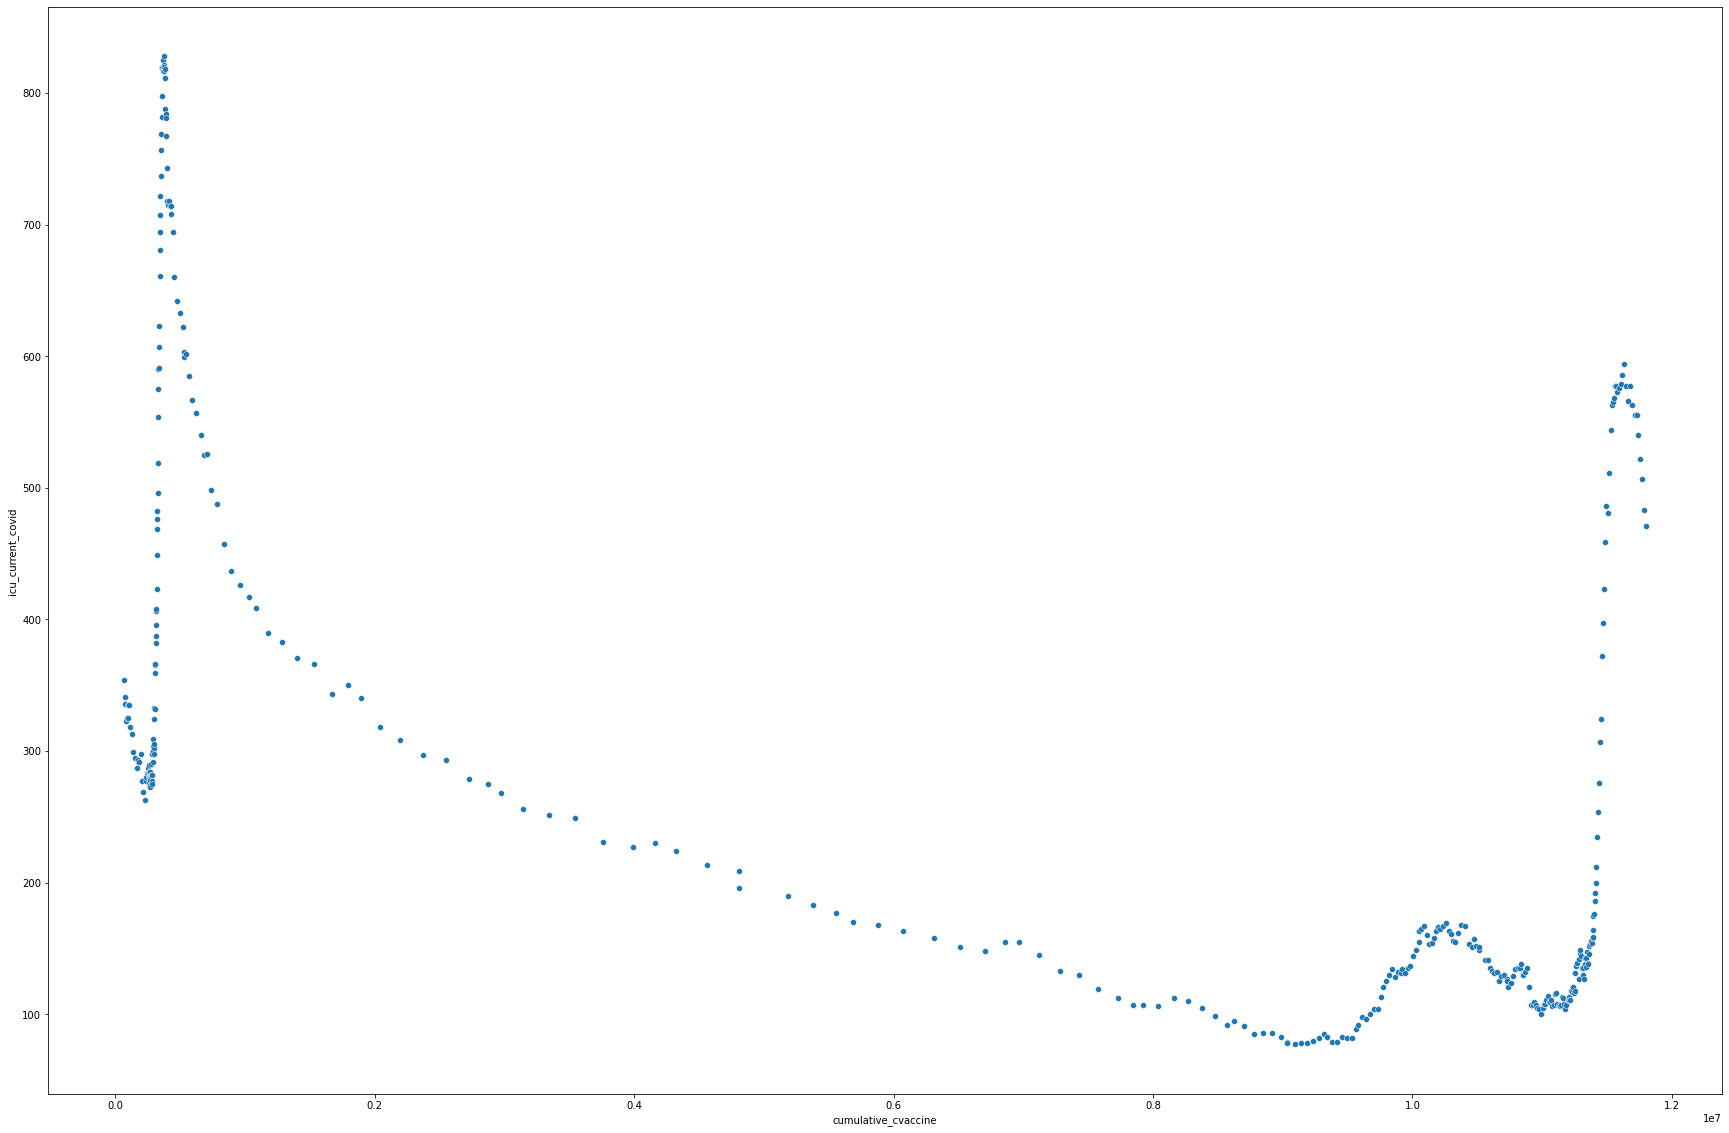

In [146]:
# Scatter plot of ICU cases and completed vaccination
plt.figure(figsize=(30,20))
sns.scatterplot(merge_covid["cumulative_cvaccine"], merge_covid["icu_current_covid"])
plt.show()

In [158]:
merge_covid["date"] = pd.to_datetime(merge_covid["date"], format ='%d-%m-%Y')
merge_covid = merge_covid[merge_covid["date"].isin(pd.date_range("2021-04-22", "2021-9-29"))]
merge_covid.head()

,date,icu_current_covid,cvaccine,cumulative_cvaccine
80,2021-04-22,757,1958.0,351354.0
81,2021-04-23,769,3854.0,355208.0
82,2021-04-24,782,3568.0,358776.0
83,2021-04-25,798,1578.0,360354.0
84,2021-04-26,820,812.0,361166.0


/Users/phnguyen296/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


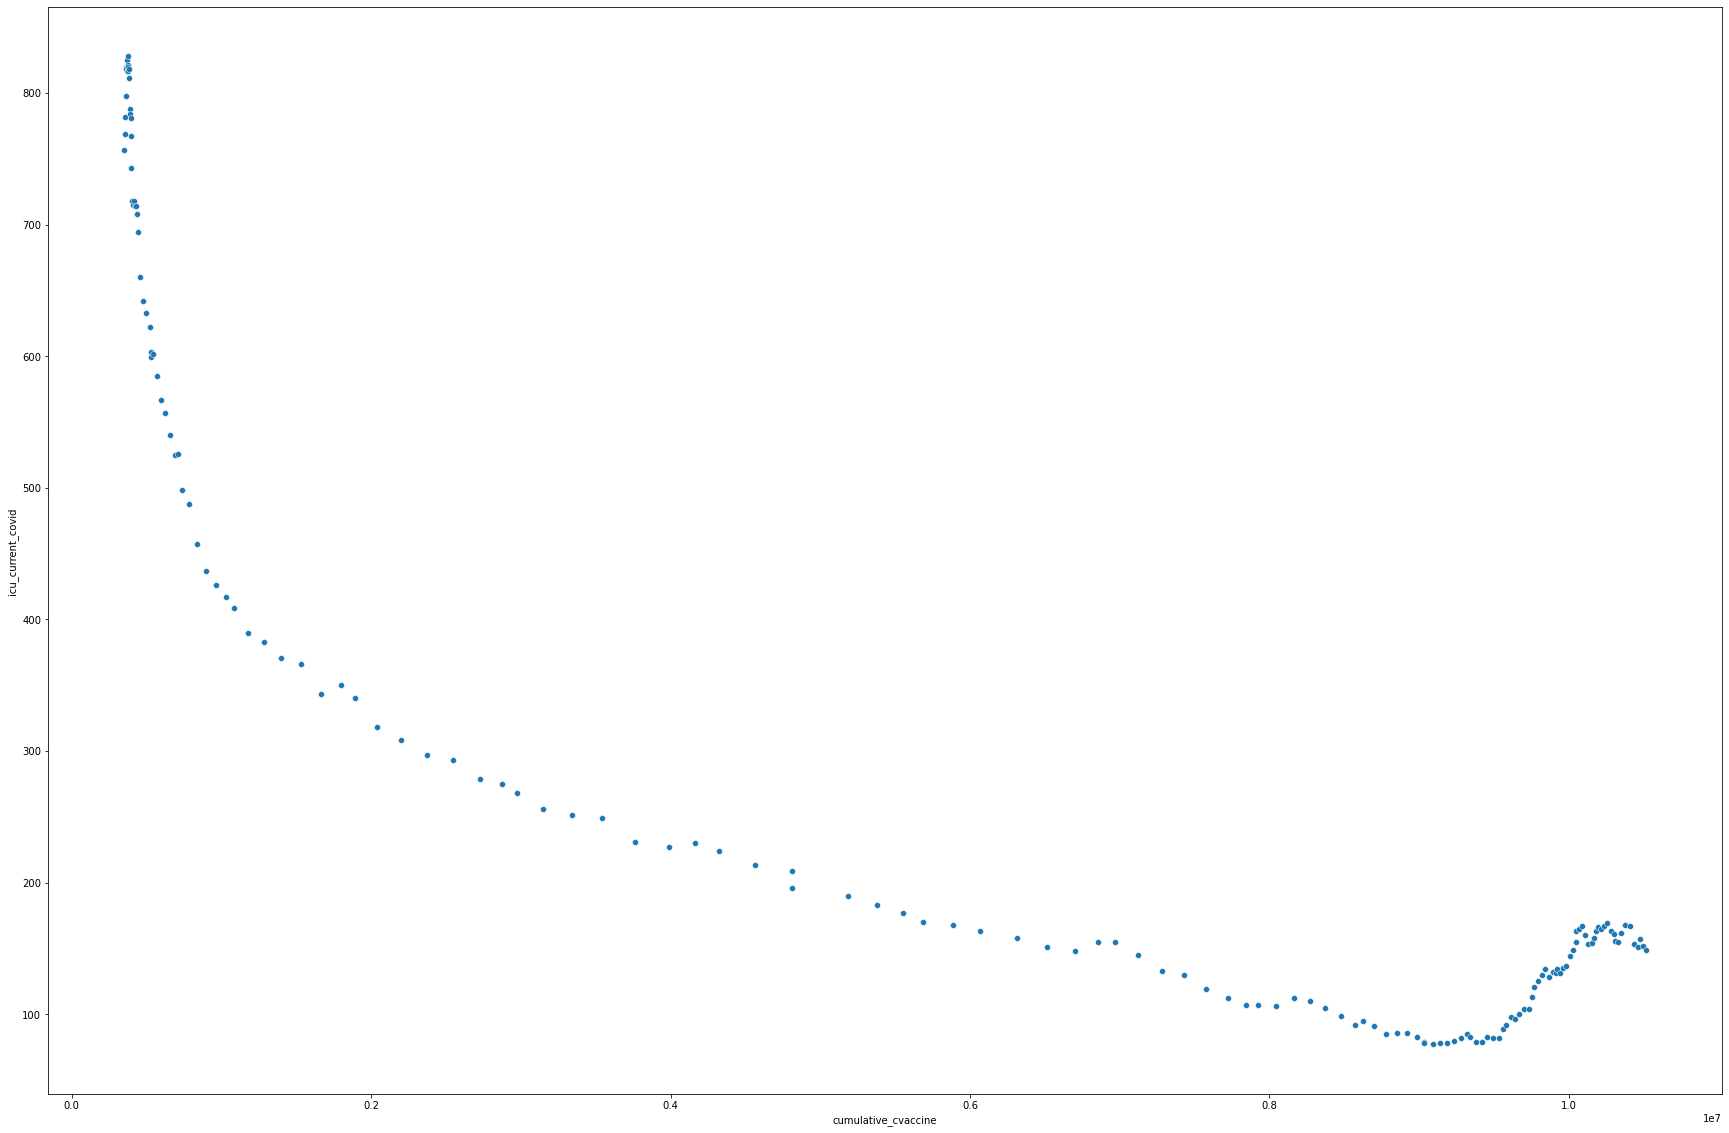

In [159]:
# Scatter plot of ICU cases and completed vaccination
plt.figure(figsize=(30,20))
sns.scatterplot(merge_covid["cumulative_cvaccine"], merge_covid["icu_current_covid"])
plt.show()

#### Supervised Machine Learning Model

After the peak in April 2021, we can observe that the growth curve of the full vaccinated cases grows exponentially. As the Government of Canada takes action on COVID-19 to protect lives and bend the curve, the growth curve starts to follow a polynomial growth rather than continuing to grow exponentially. Numerous research uses polynomial regression to predict the expected number of cases and deaths in the near future. Since polynomial fits a wide range of curvature, we will consider the polynomial regression model suitable for future prediction. To evaluate the performance of a regression model, two error metrics, Mean Squared Error (MSE) and Mean Absolute Error (MAE), will be used. After finding the best polynomial degree, we will use them for training the model and predicting number of ICU cases based on the vaccination cases. 

In [160]:
y = merge_covid.iloc[:, 1].values
X = merge_covid.iloc[:, -1:].values

In [161]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Best degree 3 with RMSE 60.04921934031789


Text(0, 0.5, 'RMSE')

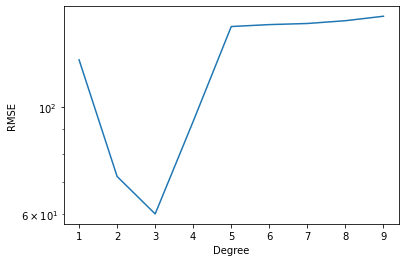

In [162]:
# Reference: [2] https://stackoverflow.com/questions/47442102/how-to-find-the-best-degree-of-polynomials.
rmses = []
degrees = np.arange(1, 10)
min_rmse, min_deg = 1e10, 0

for deg in degrees:

    # Train features
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    x_poly_train = poly_features.fit_transform(X_train)

    # Linear regression
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly_train, y_train)

    # Compare with test data
    x_poly_test = poly_features.fit_transform(X_test)
    poly_predict = poly_reg.predict(x_poly_test)
    poly_mse = mean_squared_error(y_test, poly_predict)
    poly_rmse = np.sqrt(poly_mse)
    rmses.append(poly_rmse)
    
    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg

# Plot and present results
print('Best degree {} with RMSE {}'.format(min_deg, min_rmse))
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(degrees, rmses)
ax.set_yscale('log')
ax.set_xlabel('Degree')
ax.set_ylabel('RMSE')

MSE: 3526.6695369338904
MAE: 46.59222342507131


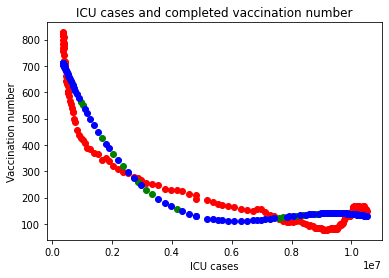

In [182]:
# Train with the best polynomial degree
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y_train)

# Visualizing the Polymonial Regression results
def viz_polymonial():
    plt.scatter(X, y, color='red')
    plt.scatter(X_test, pol_reg.predict(poly_reg.fit_transform(X_test)), color='green')
    plt.scatter(X_train, pol_reg.predict(poly_reg.fit_transform(X_train)), color='blue')
    plt.title('ICU cases and completed vaccination number')
    plt.xlabel('ICU cases')
    plt.ylabel('Vaccination number')
    print("MSE: {}\nMAE: {}".format(metrics.mean_squared_error(y_test, pol_reg.predict(poly_reg.fit_transform(X_test))), metrics.mean_absolute_error(y_test, pol_reg.predict(poly_reg.fit_transform(X_test)))))
    plt.show()
    return
viz_polymonial()

The best degree obtained was 3. Using degree 3 into the polynomial model, MAE meaning there is a variance of 46 cases between predicted and actual values. The average error between the predictions and actuals in this dataset is 46.59. The model was used to predict the ICU cases given the number of fully vaccination in real time on Oct-04-2021 with 10612380 cases. The predicted value was 126 ICU cases, which is pretty good comparing to real cases of 133. 

In [181]:
pol_reg.predict(poly_reg.fit_transform([[10612380]]))

array([126.41786334])

In [174]:
merge_covid1 = merge_covid.copy()


In [177]:
merge_covid1["date"] = pd.to_datetime(merge_covid1["date"], format ='%d-%m-%Y')
merge_covid1 = merge_covid1[merge_covid1["date"].isin(pd.date_range("2021-04-22", "2021-10-05"))]
merge_covid1.tail(8)

,date,icu_current_covid,cvaccine,cumulative_cvaccine
239,2021-09-28,152,18885.0,10493722.0
240,2021-09-29,149,23381.0,10517103.0
241,2021-09-30,151,0.0,10517103.0
242,2021-10-01,141,41860.0,10558963.0
243,2021-10-02,141,24604.0,10583567.0
244,2021-10-03,135,15890.0,10599457.0
245,2021-10-04,133,12923.0,10612380.0
246,2021-10-05,131,16752.0,10629132.0
